In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
## update data
def filter_df(df):
    thresh=8
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[df.index.get_level_values('age').isin(ages_greater)]

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

long_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet').astype(float)
long_df = long_df[keep_syllables]
long_df=filter_df(long_df)
long_df = long_df.query('age<100')

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
male_df = male_df.query('age<100')

In [6]:
# find first recording per week in the longtogeny dataset
from collections import defaultdict
ages = list(long_df.index.get_level_values('age').unique())
week_entries = defaultdict(list)
for age in ages:
    week, day = str(age).split('.')
    week_entries[week].append(age)

# Find the entry with the lowest day for each week
lowest_day_entries = [min(entries, key=lambda x: float(str(x).split('.')[1])) for entries in week_entries.values()]
long_df = long_df[long_df.index.get_level_values('age').isin(lowest_day_entries)]
long_df = long_df.rename_axis(index={'age': 'age_old'})
long_df['age'] = np.floor(long_df.index.get_level_values('age_old')).astype(int)
long_df.set_index('age',inplace=True, append=True)

# use only common ages
long_ages = long_df.index.get_level_values('age').unique().to_numpy()
m_ages = male_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(long_ages,m_ages))
male_df = male_df.loc[male_df.index.get_level_values('age').isin(cages)]
male_df['exp'] = 'ont'
male_df.set_index('exp',inplace=True,append=True)

long_df = long_df.loc[long_df.index.get_level_values('age').isin(cages)]
long_df['exp'] = 'long'
long_df.set_index('exp',inplace=True,append=True)

In [7]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# avarage per age or session
l_df= long_df.groupby(['age','uuid','mouse']).mean()
avg_l_df = l_df.groupby(['age']).mean()
# normalize the data
l_norm = mm_norm_col(l_df)
avg_l_norm = mm_norm_col(avg_l_df)

In [8]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = avg_m_norm.corrwith(avg_l_norm, axis=0, method='spearman')

p_values = avg_m_norm.apply(lambda col: spearmanr(col, avg_l_norm[col.name])[1]) #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

In [9]:
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)

In [10]:
sorted_result_df['P-Value']*len(keep_syllables)

syllables
42     0.008855
83     0.015069
62     0.024251
69     0.024251
11     0.030226
74     0.093657
16     0.093657
61     0.150000
6      0.150000
50     0.199894
12     0.199894
5      0.199894
41     0.229126
97     0.261489
23     0.261489
90     0.659704
39     0.659704
9      0.730396
4      0.730396
36     0.976224
7      1.070258
30     1.070258
76     1.277983
32     1.392185
25     2.408247
44     2.775647
59     2.775647
52     2.973404
71     3.180843
79     3.863489
13     4.371015
33     4.641124
18     6.162638
55     7.218378
68     7.594988
98     8.386005
0      8.800632
2      8.800632
54    13.119951
70    15.383850
14    15.982912
60    16.595128
85    20.540563
84    21.242585
10    24.172937
77    24.935290
24    27.290856
67    38.548723
93    41.347285
63    55.007329
73    58.000000
27    45.166073
66    42.293309
53    34.035773
17    22.683613
49    19.851053
64    15.383850
95     7.984159
Name: P-Value, dtype: float64

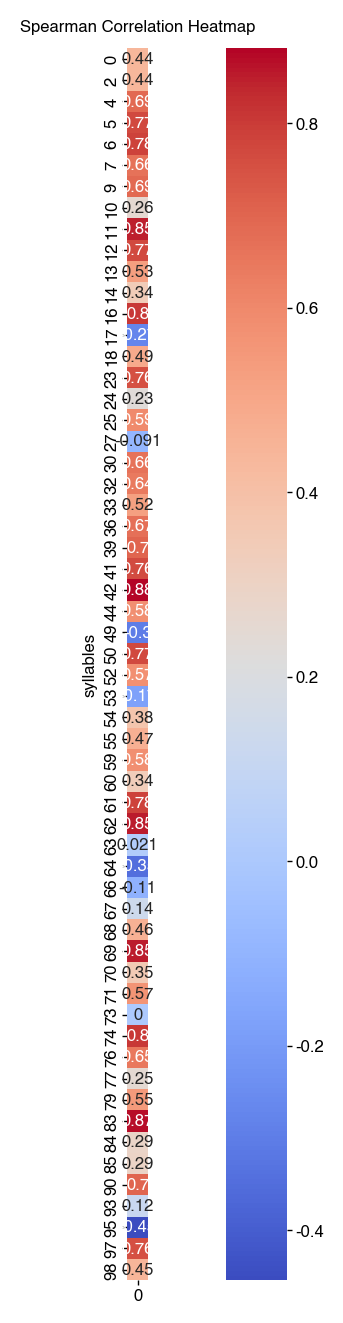

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()

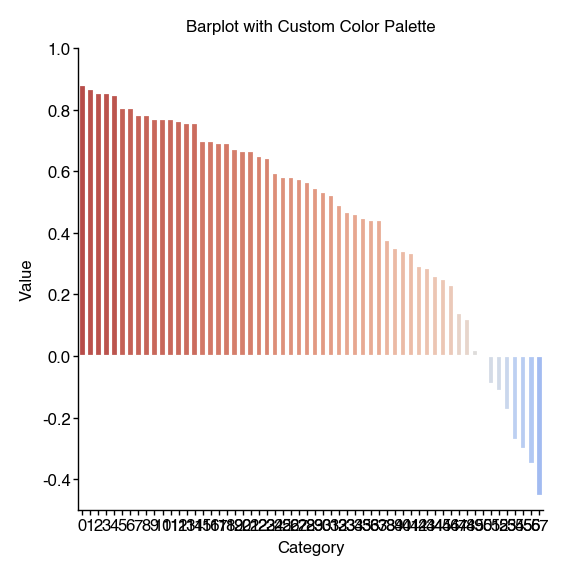

In [12]:
# Create a DataFrame from the correlation values list
from matplotlib.colors import TwoSlopeNorm
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)

# Create a DataFrame from the correlation values list
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
df = sorted_result_df.copy()
df['category'] =  -df['Correlation'].rank()
df['value'] = df['Correlation']

# Assume you have your data in a DataFrame called 'df'
# with columns 'category' and 'value'

# Get the minimum and maximum values for normalization
#min_val = df['value'].min()
#max_val = df['value'].max()

min_val = -1
max_val = 1

# Create a TwoSlopeNorm object with the desired center value (0 in this case)
norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)

# Create a colormap object based on 'RdBu_r'
cmap = plt.cm.coolwarm

# Map the normalized values to colors using the colormap
colors = cmap(norm(df['value']))

# Create a custom color palette using the mapped colors
palette = sns.color_palette(colors)

# Create the barplot using Seaborn with the custom color palette
ax = sns.barplot(x=list(range(len(sorted_result_df))), y='value', data=df, palette=palette)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Barplot with Custom Color Palette')
plt.ylim([-0.5,1])
sns.despine()
# Show the plot
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'col_syll_crosscorr.pdf')